In [56]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.sandbox.stats.multicomp import multipletests

Загрузите датасет. Файл лежит на вики

In [57]:
data = pd.read_csv('data (1).csv')
data = data.set_index('Unnamed: 0')

data = data.sort_values(by='time')
data.index.names = ['id']
data

,host,time,method,url,response,bytes
id,,,,,,
634389,199.72.81.55,804571201,GET,/history/apollo/,200,6245
2733370,unicomp6.unicomp.net,804571206,GET,/shuttle/countdown/,200,3985
607526,199.120.110.21,804571209,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,4085
607527,199.120.110.21,804571211,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,200,4179
966633,burger.letters.com,804571211,GET,/shuttle/countdown/liftoff.html,304,0
...,...,...,...,...,...,...
1396526,gatekeeper.uccu.com,809927989,GET,/images/kscmap-tiny.gif,304,0
1396527,gatekeeper.uccu.com,809927989,GET,/images/ksclogosmall.gif,304,0
1085723,cys-cap-9.wyoming.com,809927992,GET,/shuttle/missions/sts-71/movies/sts-71-launch-...,200,57344


Запросы, происходящие в некоторые моменты времени, образуют пуассоновский
процесс, смысл которого – количество запросов, обработанных сервером к текущему моменту времени.

Нарисуйте графики траектории этого пуассоновского процесса за все время и
за первые сутки (точный график, используя код с семинара).

Очевидно, красные линии рисовать не стоит, так как они будут сильно загромождать рисунок, который от этих линий лишь потеряет в качестве и понятности.

Нарисуем график за первые сутки. Чтобы график был понятнее, я по оси времени отложил часы с начала первого дня.

In [58]:
from datetime import datetime, date

first_date = datetime.fromtimestamp(data['time'].to_numpy()[0])
first_date.day

1

In [59]:
dates = [first_date]
i = 1
while dates[-1].day == first_date.day:
    dates.append(datetime.fromtimestamp(data['time'].to_numpy()[i]))
    i += 1
    
print(dates[:5])
    
for i in range(len(dates)):
    dates[i] = dates[i].timestamp()
    
first_day_beginning = datetime(first_date.year, first_date.month, first_date.day)

dates = np.array(dates) - first_day_beginning.timestamp()
dates

[datetime.datetime(1995, 7, 1, 7, 0, 1), datetime.datetime(1995, 7, 1, 7, 0, 6), datetime.datetime(1995, 7, 1, 7, 0, 9), datetime.datetime(1995, 7, 1, 7, 0, 11), datetime.datetime(1995, 7, 1, 7, 0, 11)]


array([25201., 25206., 25209., ..., 86399., 86399., 86400.])

100%|██████████| 36169/36169 [00:27<00:00, 1318.79it/s]


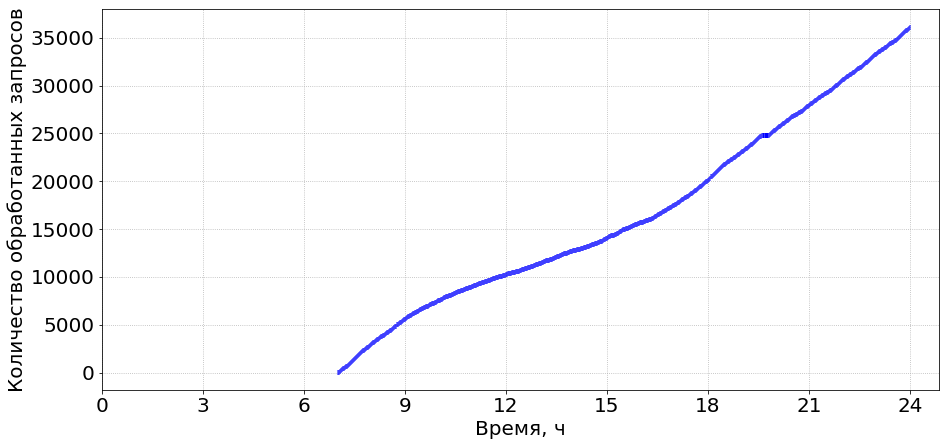

In [60]:
plt.figure(figsize=(15, 7))
for i in tqdm(range(len(dates) - 1)):
    plt.hlines(i, dates[i] / 3600, dates[i+1] / 3600, 
               lw=5, color='blue')
plt.grid(ls=':')
plt.xticks(range(0, 25, 3), fontsize=20)
plt.xlabel('Время, ч', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Количество обработанных запросов', fontsize=20)
plt.show()

Нарисуем график за все время. Стоит отметить, что ввиду слишком большого объема данных (3 млн строчек), не удается рисовать с горизонтальными линиями (ноутбук не выдерживает и зависает в процессе построения графика), поэтому довольно логичным решением видится строить просто график (так как точки расположенны настолько близко, что между ними строяшиеся горизонтальные линии незаметны, а в местах, где нет данных, линии получаются с совсем незначительным наклоном, почти горизонтальные).

In [61]:
all_dates = data['time'].to_numpy()
all_dates = (np.array(all_dates) - first_day_beginning.timestamp()) / 86400
all_dates

array([ 0.29167824,  0.29173611,  0.29177083, ..., 62.29157407,
       62.29157407, 62.29158565])

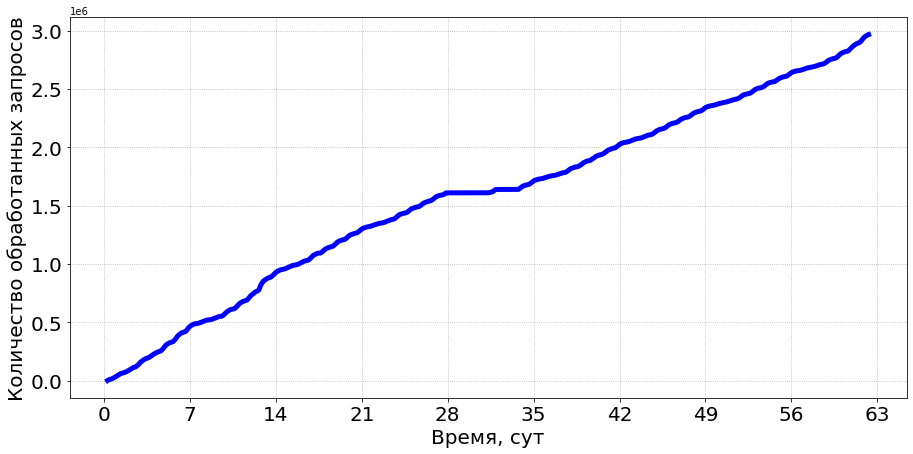

In [62]:
T = 63
plt.figure(figsize=(15, 7))
plt.plot(all_dates, np.linspace(0, len(all_dates) - 1, len(all_dates)), lw=5, color='blue')
plt.grid(ls=':')
plt.xticks(range(0, T + 1, 7), fontsize=20)
plt.xlabel('Время, сут', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Количество обработанных запросов', fontsize=20)
plt.show()

Нарисуйте так же аналогичные графики составного пуассоновского процесса,
взяв в качестве значений количество байт (bytes in the reply).

За первые сутки:

In [63]:
num_of_bytes = data['bytes'].to_numpy()[:len(dates)]
num_of_bytes = np.cumsum(num_of_bytes)
num_of_bytes

array([     6245,     10230,     14315, ..., 771793981, 772099703,
       772099703], dtype=int64)

100%|██████████| 36169/36169 [00:27<00:00, 1294.66it/s]


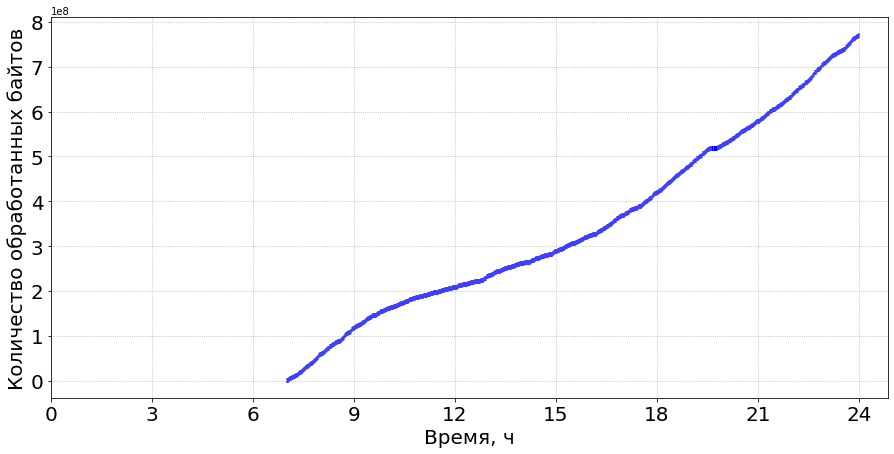

In [64]:
plt.figure(figsize=(15, 7))
for i in tqdm(range(len(dates) - 1)):
    plt.hlines(num_of_bytes[i], dates[i] / 3600, dates[i+1] / 3600, 
               lw=5, color='blue')
plt.grid(ls=':')
plt.xticks(range(0, 25, 3), fontsize=20)
plt.xlabel('Время, ч', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Количество обработанных байтов', fontsize=20)
plt.show()

За все время

In [65]:
all_num_of_bytes = data['bytes'].to_numpy()
all_num_of_bytes = np.cumsum(all_num_of_bytes)
all_num_of_bytes

array([       6245,       10230,       14315, ..., 43159938201,
       43159938716, 43159977733], dtype=int64)

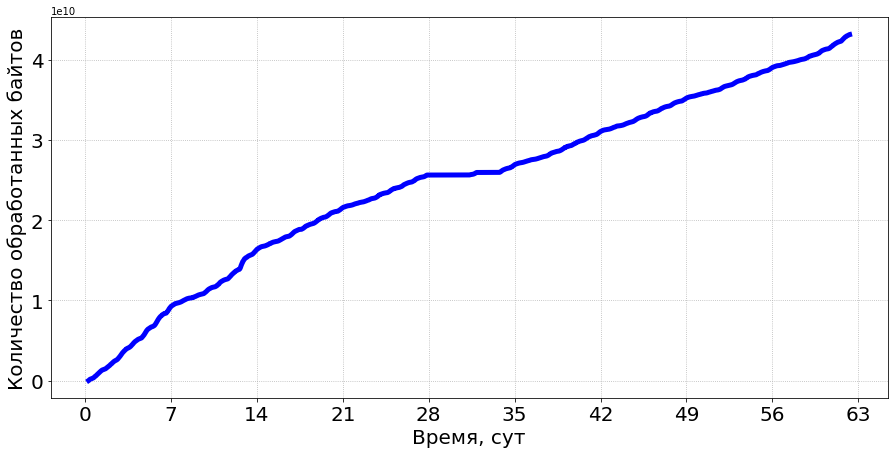

In [66]:
plt.figure(figsize=(15, 7))
plt.plot(all_dates, all_num_of_bytes, lw=5, color='blue')
plt.grid(ls=':')
plt.xticks(range(0, T + 1, 7), fontsize=20)
plt.xlabel('Время, сут', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Количество обработанных байтов', fontsize=20)
plt.show()

**Вывод по графикам:** как мы видим, процесс действительно похож на пуассоновский, однако ввиду того, что данных слишком много, разрывы становятся невидны. Стоит отметить, что примерно с во время 28 по 35 сут число запросов резко снизилось, в какой-то момент, кажется, даже нулевым, что согласуется с тем, что с 1 по 3 августа (с 32 по 34 день) данные не поступали. Также стоит отметить, что в первый месяц запросы были несколько длиннее (за первый месяц обработано примерно 60-65% байт, в то время, как просто запросов было обработано за первый месяц чуть больше половины).

Проверьте полученный пуассоновский процесс на однородность за все время,
а так же за некоторые другие интервалы времени (месяц, неделя, сутки, час).
Имеются ли интервалы, на которых процесс однороден? Чтобы проверить корректность работы реализованных критериев, можно проверить их на сгенерированных данных. Код для генерации можно взять с семинара.

Сначала напишем вспомогательные функции, которые будем использовать для получения нужного интервала времени, его деления, счета p-value и проверим их работу на сгенерированных данных, используя код с семинара.

In [67]:
def cut_time(data, left, right):
    '''
        Возвращает данные о времени обработанных запросов numpy array в период с left до right секунд.

        :param data: таблица данных pandas;
        :param left: левая граница нужного интервала; 
        :param right: правая граница нужного интервала.
    '''
    times = data['time'].to_numpy()
    times = times[times >= left]
    times = times[times < right]
    return times

In [68]:
def split_on_buckets(times, k):
    '''
        Делит данные о времени обработанных запросов на k бакетов с одинаковым временным интервалом.

        :param times: данные о времени обработанных numpy array;
        :param k: число бакетов, на которые надо поделить поступивший массив.            
    '''
    split_times = np.linspace(times[0], times[-1] + 1, k + 1)
    Z = np.digitize(times, split_times, right=False) - 1
    count = []
    for j in range(len(split_times) - 1):
        count.append(len(Z[Z == j]))
    return count

In [69]:
T = 2000
l = 1  # интенсивность

S = 0
xi = [0]  # тут будут случайные величины \xi_i. Ноль для удобства
while S < T:
    xi.append(sps.expon(scale=1/l).rvs())
    S += xi[-1]
jumps = np.cumsum(xi)  # моменты скачков

In [70]:
def count_pval(count):
    '''
    
        Считает pval по данным бакетам.
        :papam count: данные бакеты.
    
    '''
    n = np.sum(count)
    k = len(count)
    p = n / k
    chi = np.sum((count - p) ** 2) / p
    pval = sps.chi2(df=k - 1).sf(chi)
    return pval

In [71]:
count = split_on_buckets(jumps, 20)
count

[86,
 97,
 117,
 100,
 93,
 100,
 97,
 99,
 96,
 106,
 100,
 101,
 111,
 118,
 95,
 101,
 111,
 103,
 98,
 113]

In [72]:
pval = count_pval(count)
pval

0.8558853603522538

Кажется, работает. Теперь проверим однородность интенсивности за первый час.

In [73]:
times = cut_time(data, 804571201, 804574801)
len(times)

3036

In [74]:
count = split_on_buckets(times, 20)
count

[139,
 164,
 148,
 131,
 103,
 123,
 179,
 167,
 172,
 180,
 155,
 168,
 182,
 186,
 151,
 86,
 133,
 167,
 170,
 132]

In [75]:
pval = count_pval(count)
pval

9.205226490425016e-12

Интенсивность далека от однородности. Проверим теперь интенсивность на однородность на других интервалах.

In [76]:
def explore_time_interval(data, left, right, len_period, alpha):
    '''
        Вырезает временной интервал с left до right секунд, делит его на части по len_period секунд и
        исследует его пуассоновский процесс на них на однородность, проверяя его по критерию 
        с уровнем значимости alpha. Возвращает число интервалов, где гипотеза об однородности не отвергается.
        
        :param data: таблица данных pandas;
        :param left: левая граница нужного интервала; 
        :param right: правая граница нужного интервала;
        :param len_period: длина части, на которые делим и которые исследуем;
        :alpha: уровень значимости рассматриваемого критерия.
        
    '''
    periods = np.arange(left, right, len_period)
    periods_left = periods[:-1]
    periods_right = periods[1:]
    pvals = []
    for l, r in tqdm(zip(periods_left, periods_right)):
        times = cut_time(data, l, r)
        if len(times) > 30:
            count = split_on_buckets(times, int(np.log(len(times))))
            pval = count_pval(count)
            pvals.append(pval)
    reject, pvalscorr = multipletests(pvals=pvals, alpha=alpha, method='holm', is_sorted=False)[:2]
    
    cnt_agreements = len(reject[reject == 0])
         
    return cnt_agreements

Проверим однородность по дням.

In [77]:
cnt = explore_time_interval(data, data['time'].min(), data['time'].max(), 86400, 0.05)
cnt

61it [00:00, 91.34it/s] 


0

Получили, что нет ни одного дня, где интенсивность была бы однородной. Теперь проверим интенсивность по промежуткам в 5 часов.

In [78]:
cnt = explore_time_interval(data, data['time'].min(), data['time'].max(), 18000, 0.05)
cnt

297it [00:02, 108.79it/s]


0

Получили, что нет ни одного интервала в 5 часов, где интенсивность была бы однородной. Теперь проверим интенсивность по промежуткам в 1 час.

In [79]:
cnt = explore_time_interval(data, data['time'].min(), data['time'].max(), 3600, 0.05)
cnt

1487it [00:13, 108.10it/s]


215

Получили 215 часов из 1487, где гипотеза об однородности не отверглась. Это примерно 1/7 часть. 

**Вывод по исследованию однородности:** не нашлось ни одного дня и ни одного интервала в 5 часов, где интенсивность обработки сообщений была бы однородной. На самом деле, это логично, так как активность пользователей в разные часы разная (например, ночью обычно пользователи менее активны, чем днем). Отметим также, что строить по более длинным промежуткам нет смысла, так как уже получили неоднородность на уровне дней (на более больших промежутках, очевидно, неоднородность есть, так как уже на более мелкой части наблюдается неоднородность). Также получили 215 часов из 1487, где гипотеза об однородности не отверглась. Это примерно 1/7 часть. То есть, однородным процесс даже сложно считать на уровне часа.

Постройте оценку функции интенсивности следующим образом. Разбейте весь
временной интервал на небольшие равные по длине интервалы с достаточным
количеством событий в каждом интервале (например, интервалы длинною в
час). На каждом интервале оцените значение интенсивности процесса, считая
его однородным на данном интервале. В какие моменты времени наблюдается
наибольшая интенсивность?


In [80]:
def draw_intensity(data, left, right, len_period):
    '''
        Вырезает временной интервал с left до right секунд, делит его на части по len_period секунд и
        строит график интенсивности на получившихся частях.
        
        :param data: таблица данных pandas;
        :param left: левая граница нужного интервала; 
        :param right: правая граница нужного интервала;
        :param len_period: длина части, на которые делим и по которым строим график.
        
    '''
    periods = np.arange(left, right, len_period)
    periods_left = periods[:-1]
    periods_right = periods[1:]
    intensity = []
    for l, r in tqdm(zip(periods_left, periods_right)):
        times = cut_time(data, l, r)
        intensity.append(len(times) / len_period)
     
    plt.figure(figsize=(15, 7))
    plt.plot(np.linspace(0, len(intensity) - 1, len(intensity)), intensity)
    plt.grid(ls=':')
    plt.xticks(fontsize=20)
    plt.xlabel('Время, ч', fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Интенсивность, запрос/сек', fontsize=20)
    plt.show()

1487it [00:12, 119.50it/s]


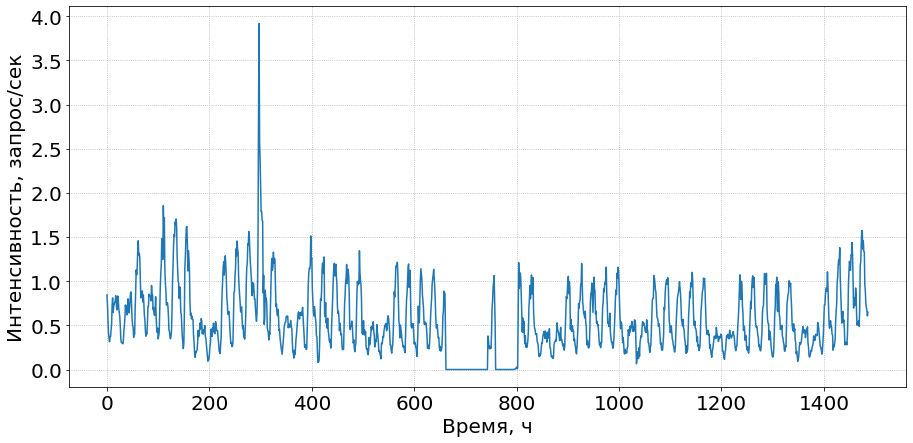

In [81]:
draw_intensity(data, data['time'].min(), data['time'].max(), 3600)

**Вывод по графику интенсивности:** видна определенная периодичность в поступлении запросов. Это логично, так как у пользователей есть примерный распорядок дня. Также заметен пик 13 июля 1995 года. Поискав информацию в интернете об этом дне, к сожалению, я не нашел повода, почему мог быть такой всплеск активности. Стоит еще отметить нулевую интенсивность в промежуток примерно с 28 июля по 3 августа. Это отлично соотносится с данными, что с 1 по 3 августа данных не поступало.